In [212]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [213]:
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_37_2201.csv")
house_load_data.columns = ['tmp']
house_load_data[['no', 'time', 'familyID','state','receivingAccumulatedActiveEnergy','sendingAccumulatedActiveEnergy','receivingActivePowery','sendingActivePower','voltage','current','date']] = pd.DataFrame(house_load_data.tmp.str.split(';',11).tolist())
house_load_data.drop('tmp',axis=1,inplace=True)

In [214]:
house_load_data.drop('receivingActivePowery',axis=1,inplace=True)
house_load_data.drop('sendingActivePower',axis=1,inplace=True)
house_load_data.drop('sendingAccumulatedActiveEnergy',axis=1,inplace=True)
house_load_data.drop('voltage',axis=1,inplace=True)
house_load_data.drop('current',axis=1,inplace=True)

In [215]:
#시계열 분해법으로 분해(시계열 형태의 ts 데이터 생성)
timeSeries = house_load_data.loc[:,["date","time","receivingAccumulatedActiveEnergy"]]
timeSeries.index = pd.to_datetime(timeSeries.time)
ts = timeSeries.drop("time", axis=1)

In [216]:
df_summary = pd.DataFrame()

#10T : 10분
df_summary['power_1h_first'] = ts.receivingAccumulatedActiveEnergy.resample('1H').first()
df_summary['power_1h_last'] = ts.receivingAccumulatedActiveEnergy.resample('1H').last()

df_summary

,power_1h_first,power_1h_last
time,,
2022-01-06 12:00:00,2953280,2953280
2022-01-06 13:00:00,2953280,2953280
2022-01-06 14:00:00,2953280,2953280
2022-01-06 15:00:00,2953280,2953280
2022-01-06 16:00:00,2953280,2953590
...,...,...
2022-01-31 19:00:00,3163010,3164620
2022-01-31 20:00:00,3164620,3165580
2022-01-31 21:00:00,3165580,3166550


In [217]:
df_summary.fillna(method='ffill', inplace=True)

In [218]:
df_summary['power'] = df_summary['power_1h_last'].astype(float)- df_summary['power_1h_first'].astype(float)
df_summary

,power_1h_first,power_1h_last,power
time,,,
2022-01-06 12:00:00,2953280,2953280,0.0
2022-01-06 13:00:00,2953280,2953280,0.0
2022-01-06 14:00:00,2953280,2953280,0.0
2022-01-06 15:00:00,2953280,2953280,0.0
2022-01-06 16:00:00,2953280,2953590,310.0
...,...,...,...
2022-01-31 19:00:00,3163010,3164620,1610.0
2022-01-31 20:00:00,3164620,3165580,960.0
2022-01-31 21:00:00,3165580,3166550,970.0


In [219]:
df_summary.index.freq = '1H'

In [220]:
weather = pd.read_csv("weather.csv", encoding='cp949')
weather

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),...,최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,106,동해,2022-01-01 01:00,-4.1,NaN,NaN,NaN,1.8,NaN,230,...,NaN,3522,NaN,NaN,-3.3,NaN,NaN,NaN,NaN,NaN
1,106,동해,2022-01-01 02:00,-3.7,NaN,NaN,NaN,2.5,NaN,250,...,NaN,2963,NaN,NaN,-3.3,NaN,NaN,NaN,NaN,NaN
2,106,동해,2022-01-01 03:00,-4.0,NaN,NaN,NaN,1.5,NaN,230,...,NaN,3002,NaN,NaN,-3.5,NaN,NaN,NaN,NaN,NaN
3,106,동해,2022-01-01 04:00,-4.1,NaN,NaN,NaN,1.6,NaN,230,...,NaN,3618,NaN,NaN,-3.6,NaN,NaN,NaN,NaN,NaN
4,106,동해,2022-01-01 05:00,-4.3,NaN,NaN,NaN,1.3,NaN,230,...,NaN,2977,NaN,NaN,-3.7,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,106,동해,2022-02-01 10:00,2.9,NaN,NaN,NaN,1.8,NaN,290,...,14.0,4826,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
754,106,동해,2022-02-01 11:00,3.2,NaN,NaN,NaN,2.7,NaN,320,...,15.0,4467,NaN,NaN,2.6,NaN,NaN,NaN,NaN,NaN
755,106,동해,2022-02-01 12:00,4.0,NaN,NaN,NaN,4.2,NaN,290,...,NaN,3417,NaN,NaN,5.6,NaN,NaN,NaN,NaN,NaN
756,106,동해,2022-02-01 13:00,3.9,NaN,NaN,NaN,3.4,NaN,320,...,NaN,2739,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN


In [221]:
data_list = []
for i in range(1,len(weather.columns)):
    if(weather.isnull().sum()[i] == 758):
        print(weather.columns[i])
        data_list.append(weather.columns[i])

기온 QC플래그
풍속 QC플래그
풍향 QC플래그
습도 QC플래그
현지기압 QC플래그
해면기압 QC플래그
일사(MJ/m2)
3시간신적설(cm)
운형(운형약어)
지면상태(지면상태코드)
현상번호(국내식)
지면온도 QC플래그
5cm 지중온도(°C)
10cm 지중온도(°C)
20cm 지중온도(°C)
30cm 지중온도(°C)


In [222]:
weather.drop(data_list, axis=1,inplace=True)
weather

,지점,지점명,일시,기온(°C),강수량(mm),강수량 QC플래그,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),...,해면기압(hPa),일조(hr),일조 QC플래그,일사 QC플래그,적설(cm),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m),지면온도(°C)
0,106,동해,2022-01-01 01:00,-4.1,NaN,NaN,1.8,230,33,1.5,...,1029.4,NaN,9.0,9,3.1,0.0,0.0,NaN,3522,-3.3
1,106,동해,2022-01-01 02:00,-3.7,NaN,NaN,2.5,250,29,1.4,...,1029.4,NaN,9.0,9,3.1,0.0,0.0,NaN,2963,-3.3
2,106,동해,2022-01-01 03:00,-4.0,NaN,NaN,1.5,230,32,1.5,...,1029.9,NaN,9.0,9,3.1,0.0,0.0,NaN,3002,-3.5
3,106,동해,2022-01-01 04:00,-4.1,NaN,NaN,1.6,230,29,1.3,...,1029.6,NaN,9.0,9,3.2,0.0,0.0,NaN,3618,-3.6
4,106,동해,2022-01-01 05:00,-4.3,NaN,NaN,1.3,230,30,1.3,...,1029.5,NaN,9.0,9,3.1,0.0,0.0,NaN,2977,-3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,106,동해,2022-02-01 10:00,2.9,NaN,NaN,1.8,290,43,3.2,...,1020.2,1.0,NaN,9,NaN,2.0,2.0,14.0,4826,0.0
754,106,동해,2022-02-01 11:00,3.2,NaN,NaN,2.7,320,36,2.8,...,1020.4,1.0,NaN,9,NaN,3.0,3.0,15.0,4467,2.6
755,106,동해,2022-02-01 12:00,4.0,NaN,NaN,4.2,290,32,2.6,...,1020.2,1.0,NaN,9,NaN,3.0,0.0,NaN,3417,5.6
756,106,동해,2022-02-01 13:00,3.9,NaN,NaN,3.4,320,33,2.7,...,1019.9,1.0,NaN,9,NaN,2.0,0.0,NaN,2739,7.0


In [223]:
weather.drop(['지점','지점명'], axis=1,inplace=True)

In [224]:

df_summary.drop(['power_1h_first','power_1h_last'], axis=1,inplace=True)
df_summary

,power
time,
2022-01-06 12:00:00,0.0
2022-01-06 13:00:00,0.0
2022-01-06 14:00:00,0.0
2022-01-06 15:00:00,0.0
2022-01-06 16:00:00,310.0
...,...
2022-01-31 19:00:00,1610.0
2022-01-31 20:00:00,960.0
2022-01-31 21:00:00,970.0


In [225]:
weather.rename(columns={'일시':'time'}, inplace=True)
weather.index = pd.to_datetime(weather.time)
weather.drop(['time'], axis=1, inplace=True)

In [226]:
df_sum = pd.merge(df_summary, weather, left_index=True, right_index=True, how='left')
df_sum.fillna(0)

,power,기온(°C),강수량(mm),강수량 QC플래그,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일조 QC플래그,일사 QC플래그,적설(cm),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m),지면온도(°C)
time,,,,,,,,,,,,,,,,,,,,
2022-01-06 12:00:00,0.0,7.2,0.0,0.0,2.6,20,26,2.6,-11.0,1020.0,1025.0,1.0,0.0,9,0.0,0.0,0.0,0.0,5000,2.2
2022-01-06 13:00:00,0.0,6.7,0.0,0.0,5.3,20,35,3.4,-7.7,1019.6,1024.6,1.0,0.0,9,0.0,0.0,0.0,0.0,5000,5.1
2022-01-06 14:00:00,0.0,6.0,0.0,0.0,6.5,20,41,3.8,-6.2,1019.6,1024.6,1.0,0.0,9,0.0,0.0,0.0,0.0,5000,6.1
2022-01-06 15:00:00,0.0,5.9,0.0,0.0,4.2,20,45,4.2,-5.1,1020.0,1025.0,1.0,0.0,9,0.0,0.0,0.0,0.0,5000,5.7
2022-01-06 16:00:00,310.0,5.1,0.0,0.0,4.2,20,47,4.1,-5.3,1020.8,1025.9,1.0,0.0,9,0.0,0.0,0.0,0.0,4967,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31 19:00:00,1610.0,4.0,0.0,0.0,3.4,290,24,1.9,-14.8,1016.4,1021.5,0.0,9.0,9,0.0,0.0,0.0,0.0,4131,0.5
2022-01-31 20:00:00,960.0,3.2,0.0,0.0,1.4,290,25,1.9,-14.9,1016.6,1021.7,0.0,9.0,9,0.0,0.0,0.0,0.0,4042,-0.1
2022-01-31 21:00:00,970.0,3.1,0.0,0.0,0.5,290,27,2.1,-14.1,1016.6,1021.7,0.0,9.0,9,0.0,6.0,6.0,36.0,3807,-0.3


In [227]:
df_sum.corr()

,power,기온(°C),강수량(mm),강수량 QC플래그,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),일조(hr),일조 QC플래그,일사 QC플래그,적설(cm),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m),지면온도(°C)
power,1.000000,-0.216586,0.397444,NaN,-0.037561,0.366108,0.216289,0.086610,0.087642,0.008000,0.011886,-0.512374,NaN,NaN,0.330015,0.131691,0.232850,0.051686,-0.107542,-0.357895
기온(°C),-0.216586,1.000000,-0.438931,NaN,-0.008688,-0.320103,0.084849,0.538438,0.539982,-0.160402,-0.176599,0.065263,NaN,NaN,-0.462630,0.283422,0.228308,-0.390957,-0.015481,0.727849
강수량(mm),0.397444,-0.438931,1.000000,NaN,0.352112,0.370234,0.447476,-0.142200,-0.132933,-0.058831,-0.037107,NaN,NaN,NaN,1.000000,-0.772343,0.234318,-0.296219,-0.718768,-0.374769
강수량 QC플래그,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
풍속(m/s),-0.037561,-0.008688,0.352112,NaN,1.000000,0.124075,-0.231230,-0.180076,-0.217368,-0.216904,-0.215946,0.225988,NaN,NaN,0.696844,-0.088316,-0.024303,-0.029215,0.179603,0.178102
풍향(16방위),0.366108,-0.320103,0.370234,NaN,0.124075,1.000000,-0.009390,-0.164176,-0.195137,-0.153014,-0.147179,-0.198068,NaN,NaN,0.376838,-0.007386,0.038217,0.096948,-0.175857,-0.407375
습도(%),0.216289,0.084849,0.447476,NaN,-0.231230,-0.009390,1.000000,0.866321,0.863006,0.380649,0.378350,-0.473014,NaN,NaN,0.113933,0.434720,0.321097,-0.594158,-0.593058,0.018862
증기압(hPa),0.086610,0.538438,-0.142200,NaN,-0.180076,-0.164176,0.866321,1.000000,0.977148,0.195587,0.186337,-0.372288,NaN,NaN,-0.493849,0.528982,0.409791,-0.624910,-0.510721,0.338802
이슬점온도(°C),0.087642,0.539982,-0.132933,NaN,-0.217368,-0.195137,0.863006,0.977148,1.000000,0.235836,0.226190,-0.347350,NaN,NaN,-0.493971,0.493010,0.362252,-0.682850,-0.514531,0.332757
현지기압(hPa),0.008000,-0.160402,-0.058831,NaN,-0.216904,-0.153014,0.380649,0.195587,0.235836,1.000000,0.999838,-0.016926,NaN,NaN,-0.269069,-0.016905,-0.032817,-0.344048,-0.010125,-0.189931


In [228]:
train_df, test_df = df_summary[:int(len(df_summary) * 0.75)], df_summary[int(len(df_summary) * 0.75):]

In [229]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

In [230]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [231]:
n_past = 48
n_future = 24
n_features = 1

In [232]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [233]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 48, 1)]      0           []                               
                                                                                                  
 lstm_36 (LSTM)                 [(None, 100),        40800       ['input_13[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_12 (RepeatVector  (None, 24, 100)     0           ['lstm_36[0][0]']                
 )                                                                                         

In [234]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,activation = 'tanh',return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, activation = 'tanh',return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, activation = 'tanh',return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, activation = 'tanh',return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 48, 1)]      0           []                               
                                                                                                  
 lstm_38 (LSTM)                 [(None, 48, 100),    40800       ['input_14[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_39 (LSTM)                 [(None, 100),        80400       ['lstm_38[0][0]']                
                                 (None, 100),                                              

In [235]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

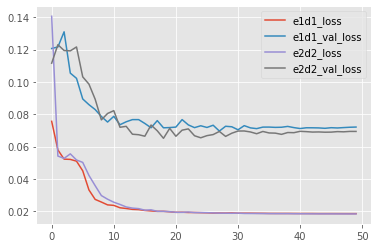

In [236]:
plt.plot(history_e1d1.history['loss'], label="e1d1_loss")
plt.plot(history_e1d1.history['val_loss'], label="e1d1_val_loss")
plt.plot(history_e2d2.history['loss'], label="e2d2_loss")
plt.plot(history_e2d2.history['val_loss'], label="e2d2_val_loss")
plt.legend()

In [237]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

In [238]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    #pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    #pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [239]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,25):
    print("Hour ",j,":")
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
    print("RRMSE-E1D1 : ",mean_squared_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index], squared=False) / np.mean(y_test),end=", ")
    print("RRMSE-E2D2 : ",mean_squared_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index], squared=False) / np.mean(y_test))
    print("R2-E1D1 : ", r2_score(y_test[:,j-1,index],pred_e1d1[:,j-1,index]) )
    print("R2-E2D2 : ", r2_score(y_test[:,j-1,index],pred_e2d2[:,j-1,index]) )
  print()
  print()

power
Hour  1 :
MAE-E1D1 :  165.71874062607927, MAE-E2D2 :  179.9631239611928
RRMSE-E1D1 :  0.561138582771978, RRMSE-E2D2 :  0.5990580099791152
R2-E1D1 :  0.492733541910808
R2-E2D2 :  0.42185916746407204
Hour  2 :
MAE-E1D1 :  172.51271310666712, MAE-E2D2 :  183.38264174577665
RRMSE-E1D1 :  0.5912945672096723, RRMSE-E2D2 :  0.61945815445853
R2-E1D1 :  0.43381834923932705
R2-E2D2 :  0.37859898047723883
Hour  3 :
MAE-E1D1 :  180.20588306101357, MAE-E2D2 :  187.1957018724302
RRMSE-E1D1 :  0.612043627781398, RRMSE-E2D2 :  0.6339911331112528
R2-E1D1 :  0.397612353825594
R2-E2D2 :  0.3536352508384405
Hour  4 :
MAE-E1D1 :  183.85778699270108, MAE-E2D2 :  188.21656639983016
RRMSE-E1D1 :  0.6225731616884588, RRMSE-E2D2 :  0.6411890807416072
R2-E1D1 :  0.380252508250006
R2-E2D2 :  0.34263553523059986
Hour  5 :
MAE-E1D1 :  188.1782968451337, MAE-E2D2 :  190.19750966676852
RRMSE-E1D1 :  0.6326148903773394, RRMSE-E2D2 :  0.6474267280899741
R2-E1D1 :  0.3622812758550713
R2-E2D2 :  0.3320690040118005


In [240]:
df_1 = pd.DataFrame(pred_e1d1[:,:,0])
df_2 = pd.DataFrame(pred_e2d2[:,:,0])

In [241]:
df_test = pd.DataFrame(y_test[:,:,0])

In [242]:
df_1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,213.342667,262.303009,344.615723,417.322083,464.668335,486.850098,490.992157,484.994141,474.739563,463.393463,...,357.993317,308.290588,244.429504,168.279770,86.351166,11.754569,-35.659004,-34.533592,26.407661,138.589035
1,267.973419,316.733612,387.113556,442.284332,473.152618,483.633575,481.537354,473.683258,464.218842,454.497253,...,328.190674,267.207947,192.304016,108.676727,27.775305,-31.793955,-47.715622,-4.321895,95.738480,229.851807
2,337.551575,377.693665,426.760284,459.750946,474.119507,475.309021,469.741577,461.836426,453.315887,443.485870,...,273.568420,200.045883,117.913284,38.508106,-20.127396,-36.610172,4.105951,99.642082,228.485275,359.615448
3,413.250977,437.629669,461.413849,472.691162,473.179749,467.599762,459.657440,450.789093,440.212677,425.516388,...,191.210846,112.417175,40.160210,-7.485162,-11.218596,39.838047,139.065872,263.288177,383.455536,476.910858
4,454.035797,464.788574,472.467316,471.918854,465.815491,457.308044,447.834564,436.763214,421.828217,399.846466,...,113.891350,43.751503,-1.767870,-4.071803,47.077602,144.697098,265.680298,381.762878,471.556152,526.548462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,594.555481,586.071594,571.093140,551.881958,531.735291,512.397095,493.705414,473.975281,450.628387,420.856537,...,153.250397,107.510284,89.560799,110.365334,171.974274,263.837189,366.170044,458.362579,526.553101,566.369934
78,590.241150,573.756714,553.417603,531.749023,510.720520,490.510406,469.681976,445.759430,415.898346,377.575775,...,101.048485,81.439522,100.799866,161.717407,253.713440,356.599335,449.357330,518.014709,558.282166,573.366516
79,603.245911,580.218872,554.279175,528.571167,503.907562,479.101959,451.729340,418.911713,378.082428,327.824341,...,82.412895,105.580597,170.480515,265.511780,369.673553,461.974609,529.159607,567.754150,581.436279,577.057190
80,585.664185,562.741699,536.598328,509.779968,482.092010,451.611359,415.687958,371.877258,318.913300,257.819885,...,111.841637,185.042969,285.599792,391.051849,480.947540,543.812622,577.927795,587.968811,581.006897,563.797302


In [243]:
df_1[0]

0     213.342667
1     267.973419
2     337.551575
3     413.250977
4     454.035797
         ...    
77    594.555481
78    590.241150
79    603.245911
80    585.664185
81    570.155457
Name: 0, Length: 82, dtype: float32

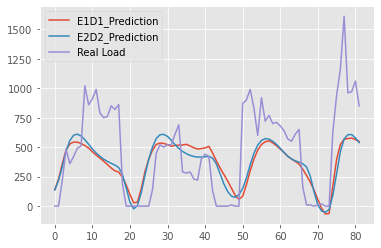

In [244]:
plt.plot(df_1[23], label="E1D1_Prediction")
plt.plot(df_2[23], label="E2D2_Prediction")
plt.plot(df_test[23], label="Real Load")
plt.legend()